# Text Mining Project Work (Group 3)

**Text Classification and Sentiment Analysis**

_Prof. Gianluca Moro, Dott. Ing. Nicola Piscaglia – DISI, University of Bologna_

**Bologna Business School** - Alma Mater Studiorum Università di Bologna

## Instructions
- The provided exercises must be executed by the students of Group 3
- At the end, the file must contain all the required results (as code cell outputs) along with all the commands necessary to reproduce them; 
- The function of every command or group of related commands
must be documented clearly and concisely.
- The submission deadline is the 1st July 2022.
- When finished, one team member will send the notebook file (having .ipynb extension) via mail (using your BBS email account) to the teacher (nicola.piscaglia@bbs.unibo.it) indicating “[BBS Teamwork] Your last names” as subject, also keeping an own copy of the file for safety.
- You are allowed to consult the teaching material and to search the Web for quick reference. 
- If still in doubt about anything, ask the teacher
- It is severely NOT allowed to communicate with other teams. Ask the teacher for any clarification about the exercises.
- Each correctly developed point counts 2/30.

## Setup

The following cell contains some necessary imports

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 101 kB 6.1 MB/s 
     |████████████████████████████████| 596 kB 27.9 MB/s 
     |████████████████████████████████| 6.6 MB 54.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
'''%%capture
!pip install tensorflow --upgrade'''

'%%capture\n!pip install tensorflow --upgrade'

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import numpy as np
import pandas as pd
import gzip
import json
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from urllib.request import urlretrieve
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Run the following to download the necessary files

In [5]:
def download(file, url):
    if not os.path.exists(file):
        urlretrieve(url, file)

In [6]:
download("Automotive_5.json.gz", "https://www.dropbox.com/s/vfpxgpoii7lpy4x/Automotive_5.json.gz?dl=1")

In [7]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Exercises

1) We provide in the `Automotive_5.json.gz` file a dataset composed by several reviews posted on Amazon.com about Automotive products. 
Each review is labeled with a score between 1 and 5 stars (represented by the ```overall``` feature).

The text of each review is represented by the ```reviewText``` feature which is going to be our input data along with the ```overall``` one.

Load the first 300000 reviews in the dataset putting it in a new Pandas dataframe.

In [8]:
df = pd.read_json('Automotive_5.json.gz', 
                  lines = True ,
                  compression = 'gzip', 
                  nrows = 300000
                  )


2) Print the dataset rows number and visualize the first 5 rows.

In [9]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,NaN,NaN
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,NaN,NaN
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,NaN,NaN


3) Undersample the data by `overall` feature in order to obtain a class-balanced dataset.



In [10]:
df['overall'].value_counts()

5    221340
4     42921
3     16445
1     11568
2      7726
Name: overall, dtype: int64

In [11]:
X = df.drop('overall', axis=1)
y = df['overall']

In [12]:
rus = RandomUnderSampler(random_state = 42)
X_r, y_r = rus.fit_resample(X, y)
y_r.value_counts()

1    7726
2    7726
3    7726
4    7726
5    7726
Name: overall, dtype: int64

4) Cast the `reviewText` column to unicode string


In [13]:
df0 = pd.DataFrame({'reviewtext': X_r['reviewText'], 'overall': y_r})
df0

,reviewtext,overall
0,Amazon fit info was wrong. Threaded connector ...,1
1,"This came recommended by a friend, so I was ha...",1
2,"My transmission is hard shift at 2sd gear, I p...",1
3,"Yea this sucked, would not stick at all",1
4,I've installed trailer lights before and they ...,1
...,...,...
38625,"Great plugs, cheaper than local parts stores, ...",5
38626,"I have some of these, but needed one more to k...",5
38627,"This is the best wash Ive found, you need very...",5
38628,they fit and work well,5


In [14]:
# list(df0['reviewtext'].dtype.value_counts().index)

In [15]:
def cast(row):
  return str(row).encode('utf-8')

df0['reviewtext'] = df0['reviewtext'].apply(cast)

In [16]:
type(df0['reviewtext'][0])

bytes

**5)** Select from data only the features named ```reviewText``` and ```overall``` putting them in a dataframe





In [17]:
df1 = df0[['reviewtext', 'overall']]
df1

,reviewtext,overall
0,b'Amazon fit info was wrong. Threaded connecto...,1
1,"b'This came recommended by a friend, so I was ...",1
2,"b'My transmission is hard shift at 2sd gear, I...",1
3,"b'Yea this sucked, would not stick at all'",1
4,"b""I've installed trailer lights before and the...",1
...,...,...
38625,"b'Great plugs, cheaper than local parts stores...",5
38626,"b'I have some of these, but needed one more to...",5
38627,"b'This is the best wash Ive found, you need ve...",5
38628,b'they fit and work well',5


**6)** Verify the distribution of the number of stars

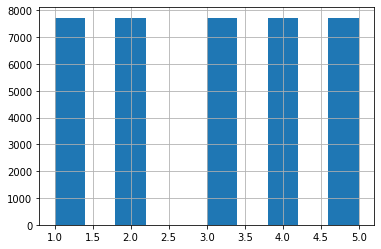

In [18]:
df1['overall'].hist()

**7)** Remove from the dataframe the reviews rated with 3 stars.

In [19]:
df2 = df1[df1['overall'] != 3].reset_index(drop=True)
df2

,reviewtext,overall
0,b'Amazon fit info was wrong. Threaded connecto...,1
1,"b'This came recommended by a friend, so I was ...",1
2,"b'My transmission is hard shift at 2sd gear, I...",1
3,"b'Yea this sucked, would not stick at all'",1
4,"b""I've installed trailer lights before and the...",1
...,...,...
30899,"b'Great plugs, cheaper than local parts stores...",5
30900,"b'I have some of these, but needed one more to...",5
30901,"b'This is the best wash Ive found, you need ve...",5
30902,b'they fit and work well',5


**8)** Add a `label` column to the DataFrame whose value is `"pos"` for reviews with 4 or 5 stars and `"neg"` for reviews with 1 or 2 stars.

In [20]:
df2.loc[df2[df2['overall'] == 1.0].index,'label'] = 'very_neg'
df2.loc[df2[df2['overall'] == 2.0].index,'label'] = 'neg'
df2.loc[df2[df2['overall'] == 4.0].index,'label'] = 'pos'
df2.loc[df2[df2['overall'] == 5.0].index,'label'] = 'very_pos'

df2

,reviewtext,overall,label
0,b'Amazon fit info was wrong. Threaded connecto...,1,very_neg
1,"b'This came recommended by a friend, so I was ...",1,very_neg
2,"b'My transmission is hard shift at 2sd gear, I...",1,very_neg
3,"b'Yea this sucked, would not stick at all'",1,very_neg
4,"b""I've installed trailer lights before and the...",1,very_neg
...,...,...,...
30899,"b'Great plugs, cheaper than local parts stores...",5,very_pos
30900,"b'I have some of these, but needed one more to...",5,very_pos
30901,"b'This is the best wash Ive found, you need ve...",5,very_pos
30902,b'they fit and work well',5,very_pos


**9)** Split the dataset randomly into a training set with 65% of data and a test set with the remaining 35%, stratifying the split by the `label` variable

In [21]:
X = df2['reviewtext'] #df2.drop(columns=['overall','label'])
y = df2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, train_size = 0.35)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10816,), (20088,), (10816,), (20088,))

**10)** Create a tf.idf vector space model from training reviews excluding words appearing in less than 7 documents and using only unigrams. Then, extract the document-term matrix for them.

In [22]:
vect = TfidfVectorizer(min_df=7)
vect.fit(X_train)

X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [23]:
vect = TfidfVectorizer(min_df=7)
train_dtm = vect.fit_transform(X_train)
train_dtm

<10816x3861 sparse matrix of type '<class 'numpy.float64'>'
	with 325720 stored elements in Compressed Sparse Row format>

**11)** Train a Multinomial Naive Bayes classifier on the training reviews, using the representation created above

In [24]:
nbc = MultinomialNB()
nbc.fit(X_train_dtm, y_train)

MultinomialNB()

In [25]:
y_pred_nbc = nbc.predict(X_test_dtm)
y_pred_nbc

array(['very_neg', 'pos', 'pos', ..., 'very_neg', 'neg', 'very_neg'],
      dtype='<U8')

**12)** Verify the accuracy of the classifier on the test set

In [26]:
print(nbc.score(X_test_dtm, y_test))
# print(accuracy_score(y_test, y_pred))

0.5418160095579451


13) Train a Deep Learning model (excluding transformer-based models like BERT) using the document-term representation built in point 10. The usage of recurrent layers is up to you.

In [27]:
def make_target(labels):
    return pd.DataFrame({
        "pos": labels == "pos", # if the label is "pos" then return 1 else return 0
        "neg": labels == "neg", # if the label is "neg" then return 1 else 0
        'very_neg' : labels == 'very_neg',
        'very_pos' : labels == 'very_pos'
    }).astype(int)

train_target = make_target(y_train)
test_target = make_target(y_test)

In [28]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [29]:
num_terms = len(vect.get_feature_names_out())
num_terms

3861

In [30]:
model = Sequential()
model.add(Dense(4, activation="softmax", input_dim=num_terms))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 15448     
Total params: 15,448
Trainable params: 15,448
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
X_train_dtm

<10816x3861 sparse matrix of type '<class 'numpy.float64'>'
	with 325720 stored elements in Compressed Sparse Row format>

In [34]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [35]:
#fit_history = model.fit(X_train_dtm, train_target, batch_size=200, epochs=10, callbacks=[GarbageCollectorCallback()])
fit_history = model.fit(X_train_dtm, np.asarray(train_target), batch_size=200, epochs=10)


Epoch 1/10
10816/10816 [==============================] - 1s 104us/step - loss: 1.3736 - accuracy: 0.3775
Epoch 2/10
10816/10816 [==============================] - 0s 26us/step - loss: 1.3443 - accuracy: 0.4820
Epoch 3/10
10816/10816 [==============================] - 0s 24us/step - loss: 1.3183 - accuracy: 0.5485
Epoch 4/10
10816/10816 [==============================] - 0s 23us/step - loss: 1.2941 - accuracy: 0.5823
Epoch 5/10
10816/10816 [==============================] - 0s 25us/step - loss: 1.2715 - accuracy: 0.5964
Epoch 6/10
10816/10816 [==============================] - 0s 24us/step - loss: 1.2502 - accuracy: 0.6174
Epoch 7/10
10816/10816 [==============================] - 0s 24us/step - loss: 1.2301 - accuracy: 0.6196
Epoch 8/10
10816/10816 [==============================] - 0s 25us/step - loss: 1.2113 - accuracy: 0.6305
Epoch 9/10
10816/10816 [==============================] - 0s 24us/step - loss: 1.1934 - accuracy: 0.6358
Epoch 10/10
10816/10816 [============================

In [36]:
'''# Garbage Collector library
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()'''

fit_history = model.fit(X_train_dtm, train_target, batch_size=200, epochs=10) #, callbacks=[GarbageCollectorCallback()]
#fit_history = model.fit(tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(X_train_dtm)), np.asarray(train_target), batch_size=200, epochs=50)

Epoch 1/10
10816/10816 [==============================] - 0s 25us/step - loss: 1.1604 - accuracy: 0.6444
Epoch 2/10
10816/10816 [==============================] - 0s 26us/step - loss: 1.1451 - accuracy: 0.6475
Epoch 3/10
10816/10816 [==============================] - 0s 26us/step - loss: 1.1307 - accuracy: 0.6533
Epoch 4/10
10816/10816 [==============================] - 0s 27us/step - loss: 1.1167 - accuracy: 0.6579
Epoch 5/10
10816/10816 [==============================] - 0s 27us/step - loss: 1.1034 - accuracy: 0.6599
Epoch 6/10
10816/10816 [==============================] - 0s 27us/step - loss: 1.0907 - accuracy: 0.6646
Epoch 7/10
10816/10816 [==============================] - 0s 25us/step - loss: 1.0786 - accuracy: 0.6683
Epoch 8/10
10816/10816 [==============================] - 0s 24us/step - loss: 1.0669 - accuracy: 0.6706
Epoch 9/10
10816/10816 [==============================] - 0s 24us/step - loss: 1.0557 - accuracy: 0.6731
Epoch 10/10
10816/10816 [==============================

14) Evaluate the model calculating the accuracy on test data. Try to maximize the model accuracy by tuning the neural network. 

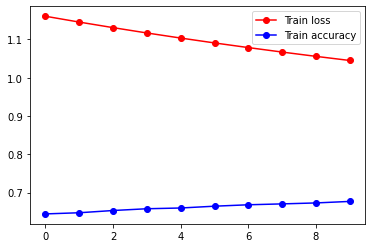

In [37]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["accuracy"], "bo-")
plt.legend(["Train loss", "Train accuracy"]);

In [38]:
y_pred = model.predict(X_test_dtm)
print(y_pred)
print(np.argmax(y_pred[0], axis=-1))

[[0.2630088  0.25586    0.24657854 0.23455265]
 [0.44226232 0.21729417 0.09608134 0.24436215]
 [0.33631983 0.17428231 0.1416037  0.34779412]
 ...
 [0.19483353 0.3688923  0.34089813 0.0953761 ]
 [0.21295421 0.31437537 0.27382493 0.19884545]
 [0.11433144 0.28572643 0.458165   0.14177711]]
0


In [39]:
def setOneToTheBest(y_p):
  for i in range(0, len(y_p)):
    y_p[i][y_p[i].argmax()] = 1
    y_p[i] = [j if j == 1.0 else 0.0 for j in y_p[i]]
    y_p[i] = [j if j == 1.0 else 0.0 for j in y_p[i]]
    y_p[i] = [j if j == 1.0 else 0.0 for j in y_p[i]]
  return y_p

In [40]:
'''
y_pred = setOneToTheBest(y_pred)
print(y_pred)

accuracy_score(np.asarray(test_target), y_pred)
'''

#accuracy_score(np.asarray(test_target).flatten(), y_pred.flatten())

'\ny_pred = setOneToTheBest(y_pred)\nprint(y_pred)\n\naccuracy_score(np.asarray(test_target), y_pred)\n'

In [41]:
print(len(y_test))
print(len(y_pred))

20088
20088


In [42]:
print("test loss, test acc:", model.evaluate(X_test_dtm, test_target))

20088/20088 [==============================] - 1s 66us/step
test loss, test acc: [1.1261206530613141, 0.5419155955314636]


15) Get the predictions of this latter model and the Multinomial Naive Bayes model (trained in point 11) ones. 

Then compare them using the McNemar test and setting a confidence level = 95%, i.e. p-value must be > 0.05 for models to be significantly similar.

To obtain the p-value, use the provided `mcnemar_pval` function providing the arrays with the labels predicted by the two models.

```
mcnemar_pval(model1_predictions, model2_predictions)
```

Hint: you will need to adapt the type of the two model predictions to integer arrays in order to be compared.

In [43]:
len(test_target)

20088

In [44]:
df_y_test = pd.DataFrame(y_test)
df_y_test[df_y_test['label'] == 'very_neg'] = 0
df_y_test[df_y_test['label'] == 'neg'] = 1
df_y_test[df_y_test['label'] == 'pos'] = 2
df_y_test[df_y_test['label'] == 'very_pos'] = 3

In [45]:
df_pred_model_1 = pd.DataFrame(y_pred_nbc)
df_pred_model_1[df_pred_model_1[0] == 'very_neg'] = 0
df_pred_model_1[df_pred_model_1[0] == 'neg'] = 1
df_pred_model_1[df_pred_model_1[0] == 'pos'] = 2
df_pred_model_1[df_pred_model_1[0] == 'very_pos'] = 3

In [46]:
df_pred_model_2 = pd.DataFrame(y_pred, columns = [0,1,2,3])

In [47]:
def mcnemar_pval(p1, p2):
  # define contingency table
  mc_table = pd.crosstab(p1, p2)
  
  print(mc_table)
  
  # calculate mcnemar test
  mc_result = mcnemar(mc_table)

  return mc_result.pvalue

In [48]:
import numpy as np
from mlxtend.evaluate import mcnemar_table

tb = mcnemar_table(y_target=np.array(df_y_test['label']).astype(float),
                   y_model1=np.array(df_pred_model_1[0]).astype(float),
                   y_model2=np.array(pd.get_dummies(df_pred_model_2).idxmax(1).astype(float)))

print('\t\tmodel1 correct\t model1 wrong')
print(' model2 correct', tb[0][0], '\t\t', tb[0][1])
print(' model2 wrong\t', tb[1][0], '\t\t', tb[1][1])

		model1 correct	 model1 wrong
 model2 correct 5166 		 990
 model2 wrong	 5718 		 8214


In [49]:
mcnemar_pval(np.array(df_pred_model_1[0]).astype(float), np.array(pd.get_dummies(df_pred_model_2).idxmax(1).astype(float)))

col_0   0.0   1.0   2.0   3.0
row_0                        
0.0      79   294  4585   183
1.0     261  4748   560   240
2.0    3262   312    88   473
3.0     187    91    95  4630


0.1743062030523537

16) Extra: train/fine-tune a transformer-based model (e.g. BERT) on training reviews and evaluate it on the test reviews.

In [50]:
from sklearn import preprocessing
import collections

# String labels conversion to integers
le = preprocessing.LabelEncoder()

train_labels1 = le.fit_transform(y_train)
collections.Counter(train_labels1)

Counter({0: 2673, 1: 2685, 2: 2680, 3: 2778})

In [51]:
# String labels conversion to integers
test_labels = le.fit_transform(y_test)
collections.Counter(test_labels)

Counter({0: 5053, 1: 5041, 2: 5046, 3: 4948})

In [52]:
train_texts, val_texts, train_labels, val_labels = train_test_split(X_train.tolist(), train_labels1, test_size=.1)

In [53]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [54]:
train_texts2 = np.array(train_texts)
val_texts2 = np.array(val_texts)
X_test2 = np.array(X_test)

In [55]:
train_texts2 = list(train_texts2.astype('str'))
val_texts2 = list(val_texts2.astype('str'))
X_test2 = list(X_test2.astype('str'))

In [56]:
train_encodings = tokenizer(train_texts2, truncation=True, padding=True)
val_encodings = tokenizer(val_texts2, truncation=True, padding=True)
test_encodings = tokenizer(X_test2, truncation=True, padding=True)

In [57]:
## PYTORCH CODE
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [58]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [59]:
from transformers import DistilBertForSequenceClassification

modelBert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

In [60]:
## PYTORCH CODE
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, BertForSequenceClassification

torch.set_grad_enabled(True) # Enable gradient calculation to perform the training

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    do_eval=True,                    # enable/disable the evaluation on the validation set during the training
    evaluation_strategy='steps',     # whether to validate the model each N steps or at the end of each epoch
    eval_steps=10                    # If evaluation strategy is set to 'steps' then the model will be evaluted each 'eval_steps' on the validation set during the training
)
# If you want to customize more the training arguments...
# https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments


trainer = Trainer(
    model=modelBert,                     # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9734
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 609


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,1.383300,1.382730,0.254159,0.133555,0.142746,0.254159
20,1.379000,1.377059,0.313309,0.246521,0.377679,0.313309
30,1.364500,1.367709,0.295749,0.224289,0.342413,0.295749
40,1.367800,1.350084,0.325323,0.262312,0.334342,0.325323
50,1.340900,1.324731,0.371534,0.319709,0.490035,0.371534
60,1.316700,1.270226,0.457486,0.407862,0.576355,0.457486
70,1.207200,1.227631,0.403882,0.311749,0.424458,0.403882
80,1.145600,1.090992,0.501848,0.435960,0.492365,0.501848
90,1.070000,1.050106,0.477819,0.393339,0.472360,0.477819
100,0.978200,1.035561,0.484288,0.432417,0.567767,0.484288


***** Running Evaluation *****
  Num examples = 1082
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 1082
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1082
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1082
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1082
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1082
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1082
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1082
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1082
  Batch size = 64
***** Running Evaluation *****
  Num examples = 10

TrainOutput(global_step=609, training_loss=0.96980144472545, metrics={'train_runtime': 1581.1374, 'train_samples_per_second': 6.156, 'train_steps_per_second': 0.385, 'total_flos': 1289483649097728.0, 'train_loss': 0.96980144472545, 'epoch': 1.0})

In [61]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 20088
  Batch size = 64


{'epoch': 1.0,
 'eval_accuracy': 0.6133014735165273,
 'eval_f1': 0.6112487166955682,
 'eval_loss': 0.820906400680542,
 'eval_precision': 0.6109203635990749,
 'eval_recall': 0.6133014735165273,
 'eval_runtime': 344.5546,
 'eval_samples_per_second': 58.301,
 'eval_steps_per_second': 0.911}

In [62]:
sentence_to_be_classified = "EXAMPLE"  # You can type an arbitrary sentence to be summarized
sentence_to_be_classified2 = "2 EXAMPLE"

In [63]:
def prova(we):
  on_demand_test_encodings = tokenizer([we], truncation=True, padding=True)
  on_demand_test_dataset = IMDbDataset(on_demand_test_encodings, le.transform(['neg']))

  result = trainer.predict(on_demand_test_dataset)
  print("Logits: " + str(result.predictions))
  return result.predictions

In [64]:
pos= prova(sentence_to_be_classified)

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


Logits: [[-0.7232507  0.8160264 -1.1479948  1.220555 ]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
neg= prova(sentence_to_be_classified2)

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


Logits: [[-0.47256863  0.6786541  -0.9710839   0.8361686 ]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
import torch
#probabilities function
def prob(we):
  # Convert logits to probabilities using softmax
  p = torch.nn.functional.softmax(torch.from_numpy(we), dim=1)
  print("Probabilities: " + str(p))

  # Get the predicted classes for each output
  top_p, top_class = p.topk(1, dim = 1)
  print("Top class: " + str(top_class[0][0].item()))

  print() 

  if (top_class.numpy()[0] == 1):
    print('The sentence polarity is positive')
  else:
    print('The sentence polarity is negative.')

In [67]:
prob(pos)

Probabilities: tensor([[0.0752, 0.3505, 0.0492, 0.5252]])
Top class: 3

The sentence polarity is negative.


In [68]:
prob(neg)

Probabilities: tensor([[0.1181, 0.3733, 0.0717, 0.4370]])
Top class: 3

The sentence polarity is negative.
